<a href="https://colab.research.google.com/github/matt-cornelius/Flip/blob/main/Practical_2_Regression_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 40868: Neural Networks - Spring 2025

## Practical Session 2 - Stock Time Series Regression with a Fully Connected Neural Network in PyTorch

Author: Benjamin Sporrer

_New: February 10, 2025_

Logistics:
 * Using the "File > Save to Github" menu above, save a copy of this notebook to your class Github repo. Maks sure you save it  in the `Practicals/Practical2` folder by prepending `Practicals/Practical2/` to the notebook file name.
 * Study and run the notebook *before class on February 10*.
 * Arrive in class ready to do some of the work required.
 * Finish up your work and commit the changes to your repo, and finish the work by 11:59pm on Monday, February 10th.

# Provided material

## 1. Import

If you add additional imports put them here.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gdown
import os

## 2. Set Device

In [2]:
# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. Create a function to load the datasets from Google Drive

In [3]:
def download_file(url, filename):
    """
    Downloads a file from a given Google Drive URL if it does not already exist.

    Parameters:
        url (str): Google Drive direct download URL.
        filename (str): Name to save the file as.
    """
    if os.path.exists(filename):
        print(f'{filename} already exists. Delete if you want to re-download it.')
    else:
        gdown.download(url, filename, quiet=False)
        print(f'Downloaded {filename}')

## 4. Load the datasets

The dataset in this notebook were created from the historical data on [Yahoo Finance](https://finance.yahoo.com/).

The four companies featured are:

*  Coca-Cola Company
*  Palantir Technologies
*  NVIDIA Corporation
*  GameStop Corporation

The csv files include all historical data available for each company up to February 6, 2025.



In [4]:
# Define files to download
files = {
    "GME.csv" : 'https://drive.google.com/uc?id=1erNijFFmyDPGKNzuKJxtBpJukNrr__uw',
    "PLTR.csv": 'https://drive.google.com/1bnVU21rvy1SYIyhFxusedNbiCrmRxLNu',
    "KO.csv": 'https://drive.google.com/uc?id=1m4K53Fpgmgx53SeJcMpQtuBJqdTIfOGy',
    "NVDA.csv": 'https://drive.google.com/uc?id=1ub0pZRanbcqEy-P4hm00bXJn6Z-bAqbj'
}

# Download each file
for filename, url in files.items():
    print(filename)
    download_file(url, filename)

# Create variable to house each csv file and stock name
gme = ("GME.csv", "GameStop Corporation")
pltr = ("PLTR.csv", "Palantir Technologies")
ko = ("KO.csv", "Coca-Cola Company")
nvda = ("NVDA.csv", "NVIDIA Corporation")

GME.csv


Downloading...
From: https://drive.google.com/uc?id=1erNijFFmyDPGKNzuKJxtBpJukNrr__uw
To: /content/GME.csv
100%|██████████| 261k/261k [00:00<00:00, 28.2MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/1bnVU21rvy1SYIyhFxusedNbiCrmRxLNu
To: /content/PLTR.csv


Downloaded GME.csv
PLTR.csv


1.65kB [00:00, 2.49MB/s]


Downloaded PLTR.csv
KO.csv


Downloading...
From: https://drive.google.com/uc?id=1m4K53Fpgmgx53SeJcMpQtuBJqdTIfOGy
To: /content/KO.csv
100%|██████████| 732k/732k [00:00<00:00, 46.8MB/s]


Downloaded KO.csv
NVDA.csv


Downloading...
From: https://drive.google.com/uc?id=1ub0pZRanbcqEy-P4hm00bXJn6Z-bAqbj
To: /content/NVDA.csv
100%|██████████| 305k/305k [00:00<00:00, 66.6MB/s]

Downloaded NVDA.csv


## 5. Create Function to Preprocess Financial Data

This function uses the ubiquitous Pandas library to do some data engineering:
 * chronological sort (using the 'Date' column - after making sure that column contains sortable dates)
 * clips the data to a specified range. None or both or either of the start date and end date can be specified as parameters to the function.
 * Normalizes the closing price between 0 and 1.

In [5]:
def preprocess_financial_data(csv_file, start_date=None, end_date=None):
    """
    Loads a financial dataset, sorts it chronologically, filters for a specified date range,
    and normalizes the 'Close' price column.

    Parameters:
        csv_file (str): Path to the CSV file.
        start_date (str or pd.Timestamp, optional): The earliest date for filtering data (format: "YYYY-MM-DD").
            If None, defaults to the minimum date in the dataset.
        end_date (str or pd.Timestamp, optional): The latest date for filtering data (format: "YYYY-MM-DD").
            If None, defaults to the maximum date in the dataset.

    Returns:
        tuple: (normalized_data, scaler, processed DataFrame)
    """
    # Load the dataset
    df = pd.read_csv(csv_file)

    # Ensure chronological order
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')

    # Determine valid date range
    min_date, max_date = df['Date'].min(), df['Date'].max()
    start_date = pd.to_datetime(start_date) if start_date else min_date
    end_date = pd.to_datetime(end_date) if end_date else max_date

    # Ensure start_date and end_date are within dataset range
    start_date = max(start_date, min_date)
    end_date = min(end_date, max_date)

    # Apply filtering
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    df.set_index('Date', inplace=True)

    # Select relevant columns
    data = df[['Close']].values

    # Normalize the data
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)

    return normalized_data, scaler, df


## 6. Preprocess Dataset

Report some results of preprocessing GameStop data.

In [6]:
# Preprocess the dataset
normalized_data, scaler, df_processed = preprocess_financial_data(gme[0], end_date="2019-01-01")

# Display first and last few rows of processed DataFrame
print("\n")
print("First rows of the dataset")
display(df_processed.head())

print("\n")
print("Last rows of the dataset")
display(df_processed.tail())



First rows of the dataset


,Open,High,Low,Close,Adj. Close,Volume
Date,,,,,,
2002-02-13,2.41,2.52,2.38,2.51,1.69,76216000
2002-02-14,2.54,2.55,2.48,2.50,1.68,11021600
2002-02-15,2.50,2.51,2.46,2.49,1.67,8389600
2002-02-19,2.47,2.47,2.34,2.39,1.61,7410400
2002-02-20,2.40,2.47,2.38,2.47,1.66,6892800




Last rows of the dataset


,Open,High,Low,Close,Adj. Close,Volume
Date,,,,,,
2018-12-24,2.99,3.01,2.91,2.92,2.82,5314000
2018-12-26,2.93,3.10,2.89,3.10,3.00,9616800
2018-12-27,3.06,3.06,2.91,3.05,2.95,7338400
2018-12-28,3.05,3.12,3.00,3.07,2.97,8105200
2018-12-31,3.08,3.17,3.08,3.15,3.05,11161200


## 7. Create Function to Generate Sequences for Time Series Forecasting

We're going to predict future stock prices from past prices. This function creates a list of (past-prices,future-price) data/target pairs that we can plug into our learning method.


In [7]:
# Create sequences for time series forecasting
def create_sequences(data, seq_length):
    """
      Generates input sequences and target values for time series forecasting.

      Args:
          data (array-like): The full time series data.
          seq_length (int): The number of time steps in each input sequence.

      Returns:
          Tuple (np.ndarray, np.ndarray):
          - sequences: Array of shape (num_samples, seq_length), each containing a sequence of past values.
          - targets: Array of shape (num_samples,), each containing the next value in the series.
      """
    sequences = []  # Stores input sequences
    targets = []    # Stores corresponding target values
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])  # Extract a sequence of 'seq_length' time steps
        targets.append(data[i+seq_length])  # Store the next value as the target
    return np.array(sequences), np.array(targets)  # Convert lists to NumPy arrays for efficiency

## 8. Create Time Series Forecasting Sequences

Use the function above to create (past-prices,future-price) pairs for the GameStop data processed above.  Also, generate a bit of debugging output for sanity-checking.

In [8]:
# Create time series forecasting sequences

seq_length = 10  # Using past 10 days to predict the next day
X, y = create_sequences(normalized_data, seq_length) #

# Create an array to store the dates associated with the predicted values
# The first predicted value occurs on the date after the first sequence
dates = df_processed.index[seq_length:]

# Print shape of input features and targets
print(f"Shape of input features: {X.shape}")
print(f"Shape of targets: {y.shape}")

# Print the first five input series and targets
# Use theses examples to verify that the target of a previous input series becomes the last entry of the new input series
for i in range(5):

  print("\n")
  print(f"Historical Sequence {i}:")
  print(X[i])

  print(f"Predicted Next Day Price {i}:")
  print(y[i])


Shape of input features: (4240, 10, 1)
Shape of targets: (4240, 1)


Historical Sequence 0:
[[0.10490921]
 [0.10423672]
 [0.10356422]
 [0.09683927]
 [0.10221923]
 [0.10154674]
 [0.09885676]
 [0.10020175]
 [0.10020175]
 [0.09683927]]
Predicted Next Day Price 0:
[0.09683927]


Historical Sequence 1:
[[0.10423672]
 [0.10356422]
 [0.09683927]
 [0.10221923]
 [0.10154674]
 [0.09885676]
 [0.10020175]
 [0.10020175]
 [0.09683927]
 [0.09683927]]
Predicted Next Day Price 1:
[0.09885676]


Historical Sequence 2:
[[0.10356422]
 [0.09683927]
 [0.10221923]
 [0.10154674]
 [0.09885676]
 [0.10020175]
 [0.10020175]
 [0.09683927]
 [0.09683927]
 [0.09885676]]
Predicted Next Day Price 2:
[0.10154674]


Historical Sequence 3:
[[0.09683927]
 [0.10221923]
 [0.10154674]
 [0.09885676]
 [0.10020175]
 [0.10020175]
 [0.09683927]
 [0.09683927]
 [0.09885676]
 [0.10154674]]
Predicted Next Day Price 3:
[0.09818426]


Historical Sequence 4:
[[0.10221923]
 [0.10154674]
 [0.09885676]
 [0.10020175]
 [0.10020175]
 [0.096839

## 9. Split the Data into Training, Validation, and Test Sets

Time to do machine learning. We're doing multiple-classifier evaluation, so we'll need training, validation, and testing sets.

In [9]:
# Ensure test set represents most recent data
split_index = int(len(X) * 0.6)
X_train, X_temp, y_train, y_temp, dates_train, dates_temp = X[:split_index], X[split_index:], y[:split_index], y[split_index:], dates[:split_index], dates[split_index:]

# Print training shapes
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of dates_train: {dates_train.shape}")
print("\n")

X_val, X_test, y_val, y_test, dates_val, dates_test = X_temp[:len(X_temp)//2], X_temp[len(X_temp)//2:], y_temp[:len(y_temp)//2], y_temp[len(y_temp)//2:], dates_temp[:len(dates_temp)//2], dates_temp[len(dates_temp)//2:]

# Print validation shapes
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of dates_val: {dates_val.shape}")
print("\n")

# Print test shapes
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of dates_test: {dates_test.shape}")

Shape of X_train: (2544, 10, 1)
Shape of y_train: (2544, 1)
Shape of dates_train: (2544,)


Shape of X_val: (848, 10, 1)
Shape of y_val: (848, 1)
Shape of dates_val: (848,)


Shape of X_test: (848, 10, 1)
Shape of y_test: (848, 1)
Shape of dates_test: (848,)


## 10. Convert data to PyTorch tensors

In order to utilize a GPU you must remember to move the tensor to the devivce.

In [10]:
# Convert to PyTorch tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

## 11. Define the Fully Connected Neural Network (FCN) Regressor

The regression model consists of:

*  An input layer with 'input_dim' neurons. The number of features in the input (length of the time series sequence).
*  Three fully connected (FC) layers.
*  ReLU activation applied after the first and second FC layers.
*  A final output layer with a single neuron to predict the stock price. Since this is a regression task, the final layer remains linear.

In regression tasks, the goal is to predict continuous values rather than classify inputs into discrete categories.

Note the style difference - the layers are defined in the constructor, but the linking-together of layers is performed explicitly in the `forward()` method.  In most past example, a `torch.nn.Sequential` tied the layers together in the constructor, which makes the `forward()` method very simple.

In [11]:
# Define the Fully Connected Neural Network (FCNN) for stock price prediction
class StockPredictor(nn.Module):
    def __init__(self, input_dim):
        super(StockPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # First fully connected layer (input to hidden)
        self.relu = nn.ReLU()  # ReLU activation function
        self.fc2 = nn.Linear(64, 32)  # Second fully connected layer
        self.fc3 = nn.Linear(32, 1)  # Output layer (predicts the stock price)

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first FC layer and ReLU activation
        x = self.relu(self.fc2(x))  # Apply second FC layer and ReLU activation
        x = self.fc3(x)  # Output layer (no activation function, as we predict a continuous value)
        return x


## 12. Create the training function

In [12]:
# Define a function to train the PyTorch model
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, num_epochs=50):
    # Lists to store training and validation loss for each epoch
    train_losses = []
    val_losses = []

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode (enables dropout, batch norm updates, etc.)
        model.train()

        # Zero the parameter gradients to avoid accumulation from previous iterations
        optimizer.zero_grad()

        # Forward pass: Compute the model's predictions for the training data
        # The input is reshaped to flatten its dimensions if necessary
        outputs = model(X_train.view(X_train.shape[0], -1))

        # Compute the loss between predictions and actual training labels
        loss = criterion(outputs, y_train)

        # Backward pass: Compute gradients for each parameter
        loss.backward()

        # Update model parameters using the optimizer
        optimizer.step()

        # Store the training loss for this epoch
        train_losses.append(loss.item())

        # Switch to evaluation mode (disables dropout, batch norm updates)
        model.eval()
        with torch.no_grad():  # Disable gradient calculation for validation (reduces memory usage)
            # Compute the model's predictions for the validation data
            val_outputs = model(X_val.view(X_val.shape[0], -1))

            # Compute the loss between predictions and actual validation labels
            val_loss = criterion(val_outputs, y_val)

            # Store the validation loss for this epoch
            val_losses.append(val_loss.item())

        # Print training and validation loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # Return the recorded training and validation losses
    return train_losses, val_losses


## 13. Create the Evaluation Function

In [13]:
# Define a function to evaluate the model's performance on test data
def evaluate_model(model, X_test, y_test, scaler):
    # Set the model to evaluation mode (disables dropout, batch norm updates, etc.)
    model.eval()

    # Disable gradient computation for inference (reduces memory usage and speeds up computation)
    with torch.no_grad():
        # Pass the test input through the model after flattening it (if necessary)
        # The output is moved to CPU and converted to a NumPy array
        predictions = model(X_test.view(X_test.shape[0], -1)).cpu().numpy()

    # Reverse the scaling transformation applied during preprocessing to get predictions in original scale
    predictions = scaler.inverse_transform(predictions)

    # Convert ground truth labels from PyTorch tensors to NumPy arrays and reverse their scaling
    y_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))

    # Return both the predicted and actual values
    return predictions, y_test


## 14. Create a Function to Plot Training and Validation Loss

In [14]:
# Define a function for plotting the loss by epoch
def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.show()


## 15. Create a Function to Plot Predictions

In [15]:
# Define a function for plotting predictions
def plot_predictions(dates_test, y_test, predictions):
    plt.figure(figsize=(10,5))
    plt.plot(dates_test, y_test, label='Actual Prices')
    plt.plot(dates_test, predictions, label='Predicted Prices')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title('Stock Price Prediction')
    plt.xticks(rotation=45)
    plt.show()


## 16. Create a Function to Print Example Predictions

In [16]:
# Define a function for displaying example predictions
def print_example_predictions(X_test, y_test, predictions, scaler, dates_test):
    print("Example Predictions vs Actuals:")
    for i in range(10):
        input_sequence = np.round(scaler.inverse_transform(X_test[i].cpu().numpy().reshape(-1, 1)).flatten(), 2)
        print(f"Date: {dates_test[i].date()} Input: {input_sequence} Predicted: {predictions[i][0]:.2f}, Actual: {y_test[i][0]:.2f}")


## 17. Instantiate the Model

Make sure the model is on the `device`.

In [17]:
# Instantiate the model
model = StockPredictor(seq_length).to(device)

# View the model's details
print(model)

StockPredictor(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


## 18. Define Loss Function and Optimizer

In regression, we're estimating a numerical target, and the loss should measure the deviation between the known value and the predicted value. `MSELoss()` is the main choice for a loss function (but there are others).

In [18]:
# Define the loss function (Mean Squared Error for regression tasks)
criterion = nn.MSELoss()

# Define the optimizer
# Note: The optimizer requires the model's parameters, so the model must be instantiated before defining the optimizer.
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 19. Train the Model

Epoch [10/50], Loss: 0.2222, Val Loss: 0.4138
Epoch [20/50], Loss: 0.1061, Val Loss: 0.2067
Epoch [30/50], Loss: 0.0305, Val Loss: 0.0605
Epoch [40/50], Loss: 0.0030, Val Loss: 0.0021
Epoch [50/50], Loss: 0.0064, Val Loss: 0.0035


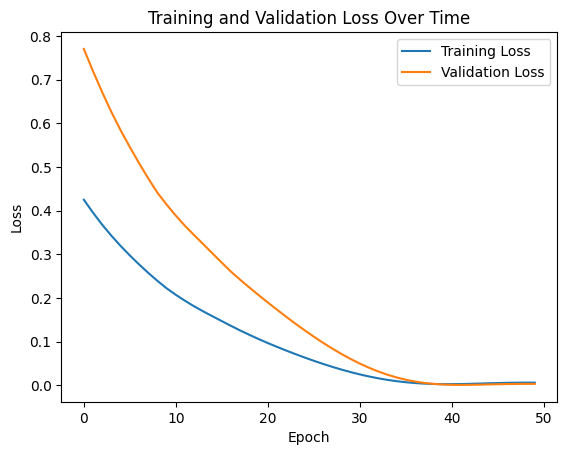

In [19]:
# Train the model
train_losses, val_losses = train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val)

# Plot the training and validation loss
plot_loss(train_losses, val_losses)

## 20. Test the Model

Example Predictions vs Actuals:
Date: 2015-08-19 Input: [11.6  11.34 11.29 11.45 11.43 11.4  11.52 11.86 11.74 11.75] Predicted: 12.22, Actual: 11.61
Date: 2015-08-20 Input: [11.34 11.29 11.45 11.43 11.4  11.52 11.86 11.74 11.75 11.61] Predicted: 12.26, Actual: 11.31
Date: 2015-08-21 Input: [11.29 11.45 11.43 11.4  11.52 11.86 11.74 11.75 11.61 11.31] Predicted: 12.21, Actual: 11.21
Date: 2015-08-24 Input: [11.45 11.43 11.4  11.52 11.86 11.74 11.75 11.61 11.31 11.21] Predicted: 12.18, Actual: 10.74
Date: 2015-08-25 Input: [11.43 11.4  11.52 11.86 11.74 11.75 11.61 11.31 11.21 10.74] Predicted: 12.07, Actual: 10.97
Date: 2015-08-26 Input: [11.4  11.52 11.86 11.74 11.75 11.61 11.31 11.21 10.74 10.97] Predicted: 12.02, Actual: 11.34
Date: 2015-08-27 Input: [11.52 11.86 11.74 11.75 11.61 11.31 11.21 10.74 10.97 11.34] Predicted: 12.03, Actual: 11.55
Date: 2015-08-28 Input: [11.86 11.74 11.75 11.61 11.31 11.21 10.74 10.97 11.34 11.55] Predicted: 12.00, Actual: 10.62
Date: 2015-08-31 Input: 

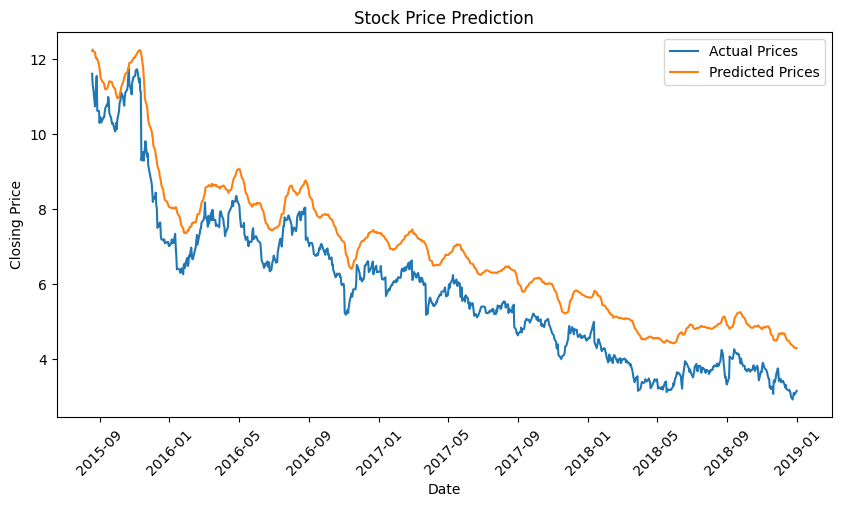

In [20]:
# Evaluate the model
predictions, y_test = evaluate_model(model, X_test, y_test, scaler)

# Print example predictions
print_example_predictions(X_test, y_test, predictions, scaler, dates_test)

# Plot all predictions
plot_predictions(dates_test, y_test, predictions)

# Student Work

## 1. Part 1: Model Analysis

1. In your opinion how did the model perform at predicting the price of the stock? Would you trust this model to pick stocks for you?

    Answer: It is hard to say what is "close" to the price without some sort of edge to compare against.  I'd say I'd trust this model since it was only off by less than a dollar the whole time.

2. Let's see how the model performs with the same stock data, but a different timeframe. Create a new dataset using the same stock, but filter the data so that it only contains data from 01/01/2021 to 04/01/2021.



In [21]:
# PRACTICAL CODE GOES HERE!

# Create your dataset below
# Hint: Use the function provided in the example.
# Make sure to filter include the correct date filter. (Reminder of date format: "YYYY-MM-DD")
normalized_data, scaler, df_processed = preprocess_financial_data(gme[0], start_date="2021-01-01", end_date="2021-04-01")

# Display first and last few rows of processed DataFrame

print("\n")
print("First rows of the dataset")
display(df_processed.head())

print("\n")
print("Last rows of the dataset")
display(df_processed.tail())

print("\n")
print(normalized_data.shape)



First rows of the dataset


,Open,High,Low,Close,Adj. Close,Volume
Date,,,,,,
2021-01-04,4.75,4.78,4.29,4.31,4.31,40090000
2021-01-05,4.34,4.52,4.31,4.34,4.34,19846000
2021-01-06,4.34,4.74,4.33,4.59,4.59,24224800
2021-01-07,4.62,4.86,4.51,4.52,4.52,24517200
2021-01-08,4.55,4.57,4.27,4.42,4.42,25928000




Last rows of the dataset


,Open,High,Low,Close,Adj. Close,Volume
Date,,,,,,
2021-03-26,49.42,54.73,40.81,45.25,45.25,149722800
2021-03-29,45.19,48.48,43.38,45.33,45.33,40168800
2021-03-30,46.88,51.08,45.50,48.62,48.62,68379600
2021-03-31,49.38,49.87,46.78,47.46,47.46,33575200
2021-04-01,48.34,49.24,45.90,47.86,47.86,37337200




(62, 1)


3. Create a testing dataset that includes the entirety of this newly filtered dataset.

In [30]:
# PRACTICAL CODE GOES HERE!

# Define your time series forecasting sequences

# Since you are using the entire dataset there is no need to redefine test specific splits.
# Make sure to create a new "Dates" variable to store the dates associated with the new sequences.

seq_length = 10  # Using past 10 days to predict the next day
# Create your input and target varibale arrays here
X, y = create_sequences(normalized_data, seq_length) # Hint: Use the function provided in the example.

dates = df_processed.index[seq_length:] # Start your dates at the date of the first target value

# Check the shape of your data
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of dates: {dates.shape}")

# Move the data to PyTorch Tensors

X_test = torch.tensor(X, dtype=torch.float32).to(device) # Convert your X array to a tensor here (Don't forget to move it to the proper device)
y_test = torch.tensor(y, dtype=torch.float32).to(device) # Convert your y array to a tensor here (Don't forget to move it to the proper device)

Shape of X: (52, 10, 1)
Shape of y: (52, 1)
Shape of dates: (52,)


4. Evaluate your model on the new test dataset.

   Hint: Use the code provided in the example as a guide.

In [ ]:
# Evaluate your model on the new test data.

predictions, y_test = evaluate_model(model, X_test, y_test, scaler)
print_example_predictions(X_test, y_test, predictions, dates_test)
plot_predictions()



4. In your opinion how did the model perform at predicting the price of the stock during this time period? Do you feel the same way you felt earlier about your model? What can you say about the reason your model's predictions succeeded or failed?

    Answer:

## Part 2: Updated models

   5. Create 4 new models with three fully connected layers. Use 20, 40, 60 and 80 hidden neurons respectively at each of the first two hidden layers. For the third hidden layer use 10, 20, 30, and 40 respectively.

   Print the details of each created model.

In [ ]:
# Define the PyTorch model
class NewStockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2):
        super(NewStockPredictor, self).__init__()
        self.fc1 = nn.Linear() # Define the first fully connected layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear() # Define the second fully connected layer
        self.fc3 = nn.Linear(, 1) # Define the third fully connected layer

    def forward(self, x):
        # Apply the layers here (Remember the last fully connected layer doesn't require an activation function for regression.)
        x =
        return x

hidden_dim_1_list = [] # First hidden layer dimension go here
hidden_dim_2_list = [] # Second hidden layer dimensions go here

paired = list(zip(hidden_dim_1_list, hidden_dim_2_list))

# Instantiate models to see details
models = []
for hidden_dim_1, hidden_dim_2 in paired:
    model =  # Instantiate the models here (Don't forget to move the models to the device).
    models.append(model)

# Print model details
for i, model in enumerate(models):
    print(f"Model {i+1}: hidden_dim_1={paired[i][0]}, hidden_dim_2={paired[i][1]}")
    print(model)

# Print model device location
for i, model in enumerate(models):
    print(f"Model {i+1} is on {next(model.parameters()).device}")

6. Run the following code and observe how the different models behave for different stocks.

  **YOU DO NOT NEED TO EDIT THIS CODE.**

In [ ]:
# Run the following code to train and test the new models

stocks = [nvda, ko, gme]

seq_length = 10  # Using past 10 days to predict the next day

for stock in stocks:
  print("-" * 200)
  print("-" * 200)
  print(stock[1])
  print("-" * 200)
  print("-" * 200)
  print("\n")

  normalized_data, scaler, df_processed = preprocess_financial_data(stock[0], start_date="2000-01-01")

  X, y = create_sequences(normalized_data, seq_length)
  dates = df_processed.index[seq_length:]

  split_index = int(len(X) * 0.6)
  X_train, X_temp, y_train, y_temp, dates_train, dates_temp = X[:split_index], X[split_index:], y[:split_index], y[split_index:], dates[:split_index], dates[split_index:]
  X_val, X_test, y_val, y_test, dates_val, dates_test = X_temp[:len(X_temp)//2], X_temp[len(X_temp)//2:], y_temp[:len(y_temp)//2], y_temp[len(y_temp)//2:], dates_temp[:len(dates_temp)//2], dates_temp[len(dates_temp)//2:]

  # Convert to PyTorch tensors and move to device
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
  X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
  y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
  y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

  for hidden_dim_1, hidden_dim_2 in paired:

    # Since the models are in a loop they must be instaniated before training to reset the intial weights.
    # A fresh model instance is needed each time, and you must explicitly create a new instance.
    # Otherwise, you are training the same instances from models repeatedly.
    model = NewStockPredictor(seq_length, hidden_dim_1, hidden_dim_2).to(device) # Don't forget to move the models to the device

    print("-" * 200)
    print(f"Model: hidden_dim_1={hidden_dim_1}, hidden_dim_2={hidden_dim_2}")
    print("-" * 200)

    # Optimizer should be reinitialized with a fresh model
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val)
    plot_loss(train_losses, val_losses)

    predictions, y_plotting = evaluate_model(model, X_test, y_test, scaler)
    print_example_predictions(X_test,  y_plotting, predictions, scaler, dates_test)
    plot_predictions(dates_test, y_plotting, predictions)

    print("\n")


7. In general how do the different models behave as the number of neurons per hidden layer increase? What could be some of the possible reasons that models don't perform well? Are there stocks in which none of the models perform well? Why might this be?

    Answer: